# Demonstrating and Testing a New Coefficient of Correlation

Author: **Marcin Sikorski**<br>
Date: June, 2024

This notebook demonstrates the usage of a coefficient of correlation similar to classic coefficients. Unlike other correlations (Pearson's, Spearman's, Kendall's), this metric does not require any assumptions on the distributions of the variables. This notebook is inspired by a [statistics paper](https://arxiv.org/pdf/1909.10140) which describes this useful coefficient.

### Quick Correlation Reminder

Pearson's correlation $r$ assumes linear relationship between exactly two variables and are normally distributed. This value can range from -1 to +1 meaning any value closer to -1 or +1 indicates strong correlation. Non-significant correlation is close to zero. Linear relationships are understood as the shape of a relationship being somewhat traceable using a straight line. This type of behavior does not often ocure in real life. Therefore, the Pearson's metric struggles for non-linear shapes.

Spearman's $\rho$ (rho) and Kendall's $\tau$ (tau) stand out as the most prominent. They are non-parametric and are used to trace non-linear shapes. Both have pros and cons and are used in specific scenarios. For example, the Kendall's $\tau$ works better for tied ranks, presence of outliers (more robust) and smaller data samples. The Spearman's $\rho$ is used for ordinal data and non-normal distributions. These measures are much better at identifying monotonic relationships and not just linear ones which makes them more robust. Monotonic relationships can basically be understood as either constantly increasing or constantly decreasing; it does not vary or change. However, if relationships are neither linear nor monotonic, these current metric do not work very well.

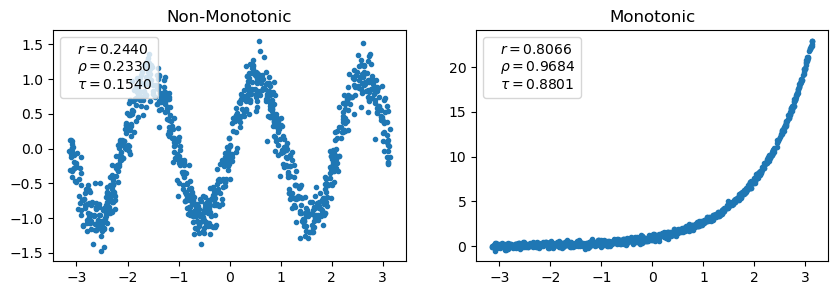

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sinusoidal function
def generate_nonmonotonic(x):
    return np.sin(3*x)

# exponential function
def generate_monotonic(x):
    return np.exp(x)

num_samples = 1_000
noise_ratio = 0.2

# non-monotonic points
nonmonotonic_data = np.random.uniform(low=-np.pi, high=np.pi, size=(num_samples, 1))
values_nonmonotonic = generate_nonmonotonic(nonmonotonic_data) + noise_ratio * np.random.normal(size=nonmonotonic_data.shape)

dfx = pd.DataFrame.from_records(nonmonotonic_data)
dfy = pd.DataFrame.from_records(values_nonmonotonic)
df_nonmon = pd.concat([dfx, dfy], axis=1)
df_nonmon.columns = ['x', 'y']

r_nonmon = r'$r=%.4f$' % df_nonmon.corr(method='pearson').iloc[0, 1]
rho_nonmon = r'$\rho=%.4f$' % df_nonmon.corr(method='spearman').iloc[0, 1]
tau_nonmon = r'$\tau=%.4f$' % df_nonmon.corr(method='kendall').iloc[0, 1]

label_nonmon = '\n'.join((r_nonmon, rho_nonmon, tau_nonmon))

# monotonic points
monotonic_data = np.random.uniform(low=-np.pi, high=np.pi, size=(num_samples, 1))
values_monotonic = generate_monotonic(monotonic_data) + noise_ratio * np.random.normal(size=monotonic_data.shape)

dfx = pd.DataFrame.from_records(monotonic_data)
dfy = pd.DataFrame.from_records(values_monotonic)
df_mon = pd.concat([dfx, dfy], axis=1)
df_mon.columns = ['x', 'y']

r_mon = r'$r=%.4f$' % df_mon.corr(method='pearson').iloc[0, 1]
rho_mon = r'$\rho=%.4f$' % df_mon.corr(method='spearman').iloc[0, 1]
tau_mon = r'$\tau=%.4f$' % df_mon.corr(method='kendall').iloc[0, 1]

label_mon = '\n'.join((r_mon, rho_mon, tau_mon))

# visualize non-monotonic data
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.scatter(nonmonotonic_data, values_nonmonotonic, marker='.', label=label_nonmon)
plt.title('Non-Monotonic')
plt.legend(markerscale=0, handlelength=0)

# visualize monotonic data
plt.subplot(1, 2, 2)
plt.scatter(monotonic_data, values_monotonic, marker='.', label=label_mon)
plt.title('Monotonic')
plt.legend(markerscale=0, handlelength=0)
plt.show()

Although there is an obvious relationship in the non-monotonic data the metrics still struggle to describe the function. The correlation measures work correctly on the exponential function - monotonic growth. Pearson's $r$ is most appropriate for linear measures while Spearman's $\rho$ and Kendall's $\tau$ work better for monotonic data.

### New Correlation

The idea of correlation is to measure the relationship between two variables. In most cases, correlation is used to identify if there exists **any** relationship. Correlation doesn't necessarily needs to identify a linear or monotonic relationship between two variables of interest or measure its exact value. Without visualizing the data it is near imposible to determine its shape.

Say we're measuring the current correlation between $X$ and $Y$. If a linear relationship does exist within the data, it can be thought of as one that is mutually shared meaning the correlation between $X$ and $Y$ is always equal to the correlation between $Y$ and $X$. With this new approach, however, we will no longer be measuring the linear relationship between $X$ and $Y$, but instead the goal is to measure how much $Y$ is a function of $X$. In general, it is not necessarily the case anymore that $\xi(X, Y)$ equals $\xi(Y, X)$.


Depending on the data we are dealing, there are two formulas describing the new correlation $\xi$ (xi or ksai). If ties in the data are impossible (or extremely unlikely), we have:

$$\xi_{n}(X, Y) = 1 - \frac{3 \sum_{i=1}^{n-1} |r_{i+1} - r_{i}|}{n^2 - 1}.$$

If ties are included, we have:

$$\xi_{n}(X, Y) = 1 - \frac{n \sum_{i=1}^{n-1} |r_{i+1} - r_{i}|}{2 \sum_{i=1}^{n}l_{i}(n - l_{i})},$$

where $l_{i}$ is defined as the number of $j$ such that $Y_{(j)} \geq Y_{(i)}$. In addition to using the second formula, to obtain the best estimate possible it is important to randomly sort the observed ties in a way that one value is chosen to be ranked higher/lower over another so that $(r_{i+1} - r_{i})$ is never equal to zero just as before. The variable $l_{i}$ is then just the number of observations $Y_{(i)}$ is actually greater than or equal to.

The $\xi$ correlation used in this notebook is based on this [Python function](https://gist.github.com/itamarfaran/0cffce51cd0e3d78ddf509b72a9e702d). We will import the function and repeat the calculations for the simulated, non-monotonic data.

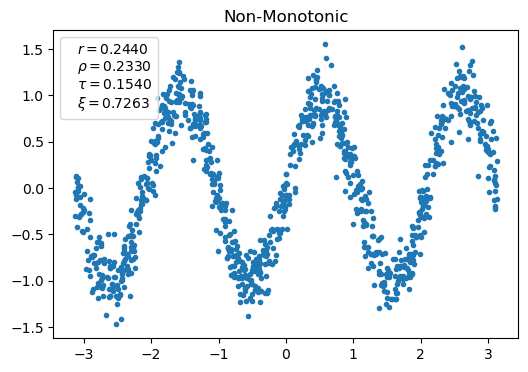

In [2]:
from new_correlation import xi_corr

xi_nonmon = r'$\xi=%.4f$' % xi_corr(x=df_nonmon['x'], y=df_nonmon['y'])[0]

new_label = '\n'.join((r_nonmon, rho_nonmon, tau_nonmon, xi_nonmon))

# new plot
plt.figure(figsize=(6, 4))
plt.scatter(nonmonotonic_data, values_nonmonotonic, marker='.', label=new_label)
plt.title('Non-Monotonic')
plt.legend(markerscale=0, handlelength=0)
plt.show()

The scatter plot above reveals the new correlation $\xi$ does a much better job with identifying the data's trend. It significantly outperforms the remaining common coefficients.

In [3]:
# parabola data
def parabola_func(x):
    return x**2

para_data = np.random.uniform(low=-4, high=4, size=(num_samples, 1))
values_para = parabola_func(para_data) + 0.2 * np.random.normal(size=para_data.shape)

dfx = pd.DataFrame.from_records(para_data)
dfy = pd.DataFrame.from_records(values_para)
df_para = pd.concat([dfx, dfy], axis=1)
df_para.columns = ['x', 'y']

# linear data
def linear_func(x):
    return -0.5*x

lin_data = np.random.uniform(low=-4, high=4, size=(num_samples, 1))
values_lin = linear_func(lin_data) + 0.4 * np.random.normal(size=lin_data.shape)

dfx = pd.DataFrame.from_records(lin_data)
dfy = pd.DataFrame.from_records(values_lin)
df_lin = pd.concat([dfx, dfy], axis=1)
df_lin.columns = ['x', 'y']

# cosine data
def cosine_func(x):
    return np.cos(4*x)

cos_data = np.random.uniform(low=-4, high=4, size=(num_samples, 1))
values_cos = cosine_func(cos_data) + 0.4 * np.random.normal(size=cos_data.shape)

dfx = pd.DataFrame.from_records(cos_data)
dfy = pd.DataFrame.from_records(values_cos)
df_cos = pd.concat([dfx, dfy], axis=1)
df_cos.columns = ['x', 'y']

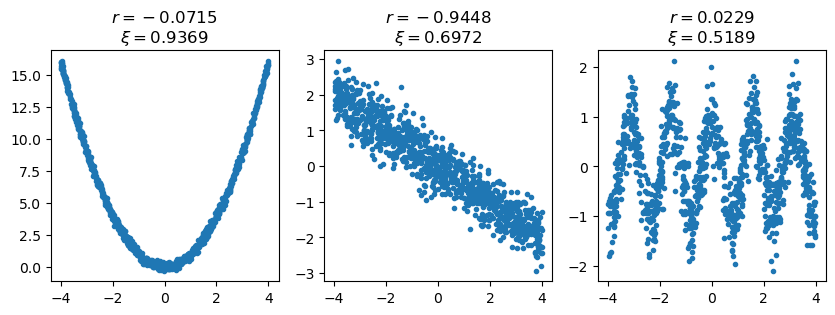

In [4]:
r_para = r'$r=%.4f$' % df_para.corr(method='pearson').iloc[0, 1]
xi_para = r'$\xi=%.4f$' % xi_corr(x=df_para['x'], y=df_para['y'])[0]
label_para = '\n'.join((r_para, xi_para))

r_lin = r'$r=%.4f$' % df_lin.corr(method='pearson').iloc[0, 1]
xi_lin = r'$\xi=%.4f$' % xi_corr(x=df_lin['x'], y=df_lin['y'])[0]
label_lin = '\n'.join((r_lin, xi_lin))

r_cos = r'$r=%.4f$' % df_cos.corr(method='pearson').iloc[0, 1]
xi_cos = r'$\xi=%.4f$' % xi_corr(x=df_cos['x'], y=df_cos['y'])[0]
label_cos = '\n'.join((r_cos, xi_cos))

# parabolic data
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.scatter(para_data, values_para, marker='.')
plt.title(label_para)

# linear data
plt.subplot(1, 3, 2)
plt.scatter(lin_data, values_lin, marker='.')
plt.title(label_lin)

# cosine data
plt.subplot(1, 3, 3)
plt.scatter(cos_data, values_cos, marker='.')
plt.title(label_cos)
plt.show()

Firstly, the new approach no longer displays the direction of the relationship; the values are no longer negative. However, a value closer to 1 shows stronger relationship and closer to 0 shows weak relationship. In other words, 0 if and only if the variables are independent and 1 if and only if one is a measurable function of the other. Thus, $\xi$ gives an actual measure of the strength of the relationship.

Starting from the left Pearson's $r$ concludes there is no significant relationship between $X$ and $Y$ when we clearly note a parabolic one. The middle example shows both measures working correctly. The Pearson's correlation still has advantage for linear data displaying the direction of the trend and stronger relationship. The third example shows the same method concludes there's no correlation when in reality the relationship appears to exhibit periodic and seasonal trend. The new correlation $\xi$ captures the trend significantly better.

Lastly, we will test the new correlation approach with a real-world example. Suppose we want to measure the level of independence between brain signals and time. We will import data of brain activity measured in the form of BOLD signals using functional magnetic resonance imaging (fMRI). This dataset is available in the `astsa` package. The data contains the average response observable in eight various brain locations in the cortex, thalamus, and cerebellum across five subjects. Each of the following subject was exposed to periodic brushing of the hand for 32 seconds and then paused for 32 seconds resulting in a signal period of 64 seconds. The data was then recorded every 2 seconds for 256 seconds total ($n = 128$).

In [5]:
# load fMRI data
github_url = 'https://raw.githubusercontent.com/evorition/astsadata/main/astsadata/data/fmri1.csv'
fmri = pd.read_csv(github_url)

print('Number of records: {}'.format(len(fmri)))

# show first rows
fmri.head()

Number of records: 128


,time,cort1,cort2,cort3,cort4,thal1,thal2,cere1,cere2
0,1,-0.336,-0.088,-0.579,-0.221,-0.222,-0.046,-0.354,-0.028
1,2,-0.192,-0.359,-0.475,-0.058,0.072,-0.039,-0.346,-0.032
2,3,0.062,0.062,0.063,0.192,0.145,-0.256,-0.337,0.272
3,4,0.128,0.221,0.234,-0.004,-0.104,-0.030,0.149,0.042
4,5,0.358,0.199,0.388,0.255,0.035,-0.081,0.311,-0.080


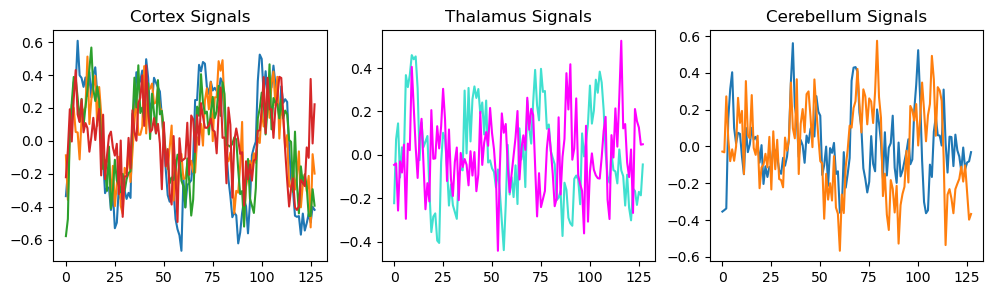

In [6]:
# cortex
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
fmri['cort1'].plot()
fmri['cort2'].plot()
fmri['cort3'].plot()
fmri['cort4'].plot()
plt.title('Cortex Signals')

# thalamus
plt.subplot(1, 3, 2)
fmri['thal1'].plot(color='turquoise')
fmri['thal2'].plot(color='magenta')
plt.title('Thalamus Signals')

# cerebellum
plt.subplot(1, 3, 3)
fmri['cere1'].plot()
fmri['cere2'].plot()
plt.title('Cerebellum Signals')
plt.show()

In case we wish to determine which of these three parts of the brain is most likely a function of time implying they are most involved when performing the prescribed stimulation. The graphs above display the cortex signals to be the least noisy and the thalamus signals appear to be the noisiest. We will quantify this using correlation statistics.

In [7]:
# define lists
pearson_list = []
spearman_list = []
kendall_list = []
new_corr_list = []

columns = ['cort1', 'cort2', 'cort3', 'cort4', 'thal1', 'thal2', 'cere1', 'cere2']
areas = ['Cortex 1', 'Cortex 2', 'Cortex 3', 'Cortex 4', 'Thalamus 1', 'Thalamus 2', 'Cerebellum 1', 'Cerebellum 2']

# loop over each column
for i in columns:
    pearson_list.append(fmri['time'].corr(fmri[i], method='pearson'))
    spearman_list.append(fmri['time'].corr(fmri[i], method='spearman'))
    kendall_list.append(fmri['time'].corr(fmri[i], method='kendall'))
    new_corr_list.append(xi_corr(x=fmri['time'], y=fmri[i])[0])
    
# show correlation results
pd.DataFrame(list(zip(areas, pearson_list, new_corr_list)),
             columns=['Brain Area', "Pearson's r", 'New Correlation 𝜉']).style.hide(
    axis='index').set_properties(subset=['Brain Area'], **{'font-weight': 'bold'})

Brain Area,Pearson's r,New Correlation 𝜉
Cortex 1,-0.204751,0.637991
Cortex 2,-0.170512,0.462234
Cortex 3,-0.188985,0.507380
Cortex 4,-0.124625,0.295353
Thalamus 1,-0.153267,0.521366
Thalamus 2,0.073647,0.162249
Cerebellum 1,-0.027524,0.338317
Cerebellum 2,-0.139616,0.443211


The common approach for correlation consistently exhibits each of these relationships to be negative or approximately zero. Just as there is little to no observable relationship, and if there is any it exhibits a negative trend. Based on the previous visuals this not the case. Some of these signals exhibit visibly strong relationships with time, and all of them appear to have no clear trend. The new correlation displays a much better performance identifying which location is least noisy, which is the main point of this analysis. The cortex is mostly used during the period of stimulation since those correlation values are the highest on average. Some parts of the thalamus appear to be involved as well, which was not easy to detect on the plot and was noted as the noisiest.

### Summary

This basic notebook was created to introduce and showcase computation examples of a new correlation on simulated and real-life data. The generated examples purposely had different shapes. Based on correlation values the new coefficient $\xi$ proves to be more powerful in identifying the data's trends. The new approach is still far from perfect, but it was created as a means of solving some of the most notable issues with the currently accepted approach. The new coefficient of correlation has the following advantages:
* requires no assumptions on the distributions of the variables,
* it has a simple formula as the classical competitors,
* it is easy to interpretate and measure the degree of dependence between the variables,
* has a simple asymptotic theory under the hypothesis of independence,
* works well with non-monotonic data,
* $\xi$ seems to be more effective than other tests for detecting oscillatory signals.

Further development can include performing an official hypothesis test of independence using the asymptotic theory which was derived in the official publication.

### References

* S. Chatterjee, 2020, *A New Coefficient of Correlation*, [Full Text](https://arxiv.org/pdf/1909.10140)
* https://cran.r-project.org/web/packages/XICOR/index.html [Accessed: 18.06.2024]
* https://statisticseasily.com/kendall-tau-b-vs-spearman/ [Accessed: 18.06.2024]
* https://towardsdatascience.com/a-new-coefficient-of-correlation-64ae4f260310 [Accessed: 18.06.2024]